<h1>Comércio eletrônico brasileiro</h1>
<br>
Dataset disponível no <a href='https://www.kaggle.com/olistbr/brazilian-ecommerce'>Kaggle</a>
<br>
Este conjunto de dados possui informações de 100 mil pedidos feitos entre 2016 e 2018 feito em diversos mercados eletrônicos do Brasil. Seus recursos permitem a visualização de um pedido em múltiplas dimensões: desde o status do pedido, preço, desempenho de pagamento e frete até a localização do cliente, atributos do produto e, finalmente, avaliações escritas pelos clientes.
<br>
<br>
São dados comerciais reais, porém anonimizados, então as referências às empresas e parceiros no texto da avaliação foram substituídas pelos nomes das grandes casas de Game of Thrones.
<br>
<br>
É um conjunto de dados muito rico de informações e podemos ter vários insights, como: 
<br>
- O tipo de pagamento preferido dos clientes;
<br>
- Quais categorias vendem mais;
<br>
- Preços médios das 4 categorias de produtos mais vendidas;
<br>
- Qual a tendência das vendas no tempo;
<br>
- Desempenho de entrega;
<br>
- Quais categorias de produtos possuem clientes satisfeitos e insatisfeitos;
<br>

<h1>Pergunta Principal</h1>
<br>
Tentarei responder uma pergunta principal: <b>Como deixar os clientes mais satisfeitos com as compras do comércio eletrônico no Brasil?</b>

In [1]:
# Importando as bibliotecas necessárias para a análise
%matplotlib inline 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from scipy.stats import skew,kurtosis
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ja_me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Lendo arquivos
clientes = pd.read_csv('olist_customers_dataset.csv')
itens_pedido = pd.read_csv('olist_order_items_dataset.csv')
pagamentos = pd.read_csv('olist_order_payments_dataset.csv')
avaliacoes = pd.read_csv('olist_order_reviews_dataset.csv')
pedidos = pd.read_csv('olist_orders_dataset.csv')
produtos = pd.read_csv('olist_products_dataset.csv')
vendedores = pd.read_csv('olist_sellers_dataset.csv')

In [3]:
# Quantidade de linhas e colunas de cada DataFrame
clientes.shape

(99441, 5)

In [4]:
itens_pedido.shape

(112650, 7)

In [5]:
pagamentos.shape

(103886, 5)

In [6]:
avaliacoes.shape

(100000, 7)

In [7]:
pedidos.shape

(99441, 8)

In [8]:
produtos.shape

(32951, 9)

In [9]:
vendedores.shape

(3095, 4)

In [10]:
# Juntando os conjuntos de dados
pedidos_pagamentos = pd.merge(pedidos, pagamentos, how="left",on=['order_id','order_id'])
pedidos_pagamentos_avaliacoes = pd.merge(pedidos_pagamentos, avaliacoes, how="left",on=['order_id','order_id'])
pedidos_pagamentos_avaliacoes_itens = pd.merge(pedidos_pagamentos_avaliacoes, itens_pedido, how="left",on=['order_id','order_id'])
pedidos_pagamentos_avaliacoes_itens_clientes = pd.merge(pedidos_pagamentos_avaliacoes_itens, clientes, how='left', on=['customer_id', 'customer_id'])
pedidos_pagamentos_avaliacoes_itens_clientes_produtos = pd.merge(pedidos_pagamentos_avaliacoes_itens_clientes, produtos, how='left', on=['product_id', 'product_id'])
df = pd.merge(pedidos_pagamentos_avaliacoes_itens_clientes_produtos, vendedores, how='left', on=['seller_id', 'seller_id'])

<h1><b>Tratamento dos dados</b></h1>
<br>
<b>Para os dados nulos</b>, não farei nenhum tratamento de forma geral, pois não quero influenciar nas estatísticas descritivas e também não quero apagar as linhas, pois mesmo faltando algum dado em determinada coluna, será importante para a análise. As únicas colunas que tratarei serão relacionados à data, pois será importante com o passar do tempo, mas mesmo assim, não será alterado os valores nulos.
<br>
<br>
<b>Este conjunto de dados não possui valores duplicados.</b>
<br>
<br>
<b>As colunas que serão tratadas são:</b>
<br>
- order_purchase_timestamp
<br>
- order_approved_at
<br>
- order_delivered_carrier_date
<br>
- order_delivered_customer_date
<br>
- order_estimated_delivery_date
<br>
- shipping_limit_date

In [11]:
# Verificando o tipo de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119151 entries, 0 to 119150
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119151 non-null  object 
 1   customer_id                    119151 non-null  object 
 2   order_status                   119151 non-null  object 
 3   order_purchase_timestamp       119151 non-null  object 
 4   order_approved_at              118974 non-null  object 
 5   order_delivered_carrier_date   117065 non-null  object 
 6   order_delivered_customer_date  115730 non-null  object 
 7   order_estimated_delivery_date  119151 non-null  object 
 8   payment_sequential             119148 non-null  float64
 9   payment_type                   119148 non-null  object 
 10  payment_installments           119148 non-null  float64
 11  payment_value                  119148 non-null  float64
 12  review_id                     

In [12]:
# Verificando quais colunas possuem dados nulos
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                             0
review_score                          0
review_comment_title             104962
review_comment_message            67901
review_creation_date                  0
review_answer_timestamp               0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
customer_unique_id                    0


In [13]:
# Transformando colunas de datas em Datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

<h1>O tipo de pagamento preferido dos clientes</h1>
<br>

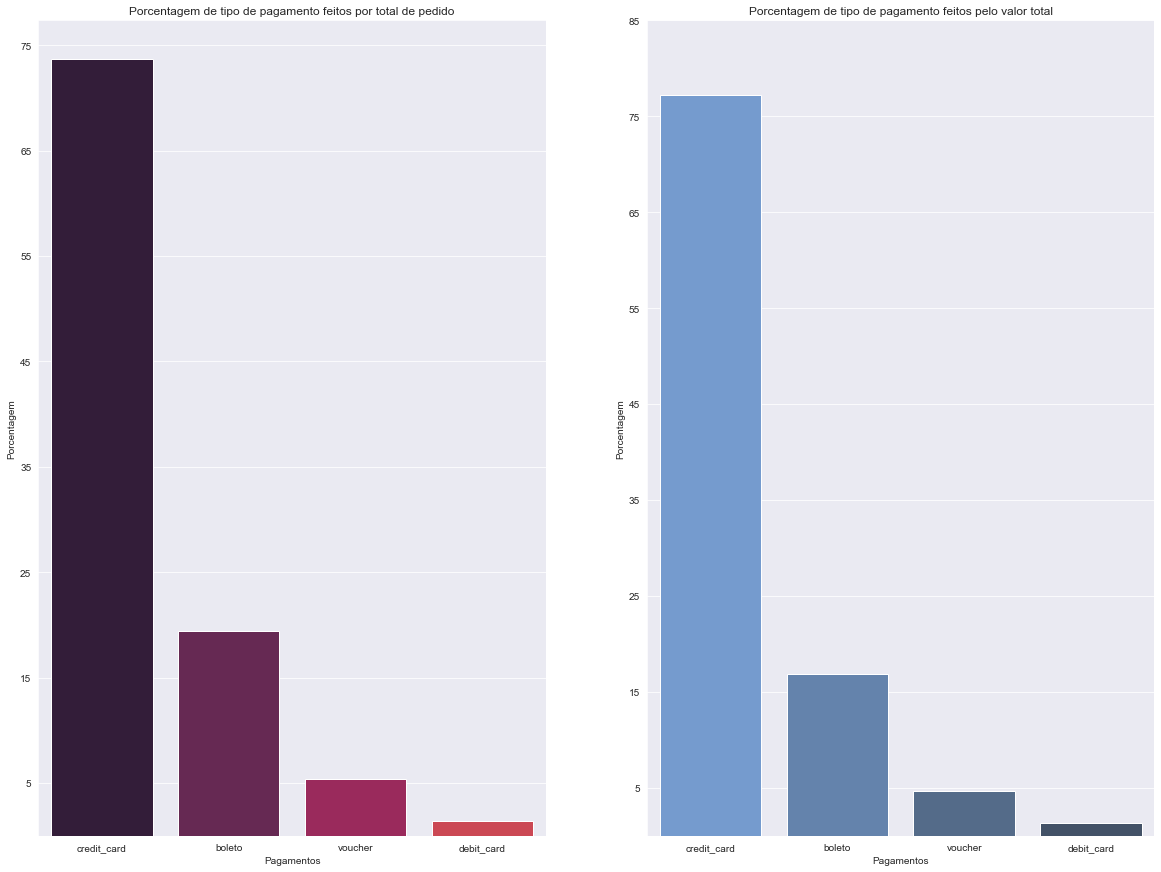

In [14]:
porcentagem_contagem_total = (df['payment_type'].value_counts() / df['payment_type'].value_counts().sum()) *100
porcentagem_contagem_total = porcentagem_contagem_total.to_frame().reset_index()
contagem_por_preco = df.groupby('payment_type')['price'].sum().to_frame().reset_index()
contagem_por_preco['Porcentagem'] = (contagem_por_preco['price'] / contagem_por_preco['price'].sum()) *100
contagem_por_preco = contagem_por_preco.sort_values(by='Porcentagem', ascending=False)

palette1 = sns.color_palette("rocket")
palette2 = sns.dark_palette("#69d", reverse=True)
sns.set_style("darkgrid")
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
sns.barplot(x='index', y='payment_type', data=porcentagem_contagem_total[:4], palette=palette1)
plt.yticks([5, 15, 25, 35, 45, 55, 65, 75])
plt.title('Porcentagem de tipo de pagamento feitos por total de pedido')
plt.xlabel('Pagamentos')
plt.ylabel('Porcentagem')
plt.subplot(1, 2, 2)
sns.barplot(x='payment_type', y='Porcentagem', data=contagem_por_preco[:4], palette=palette2, order=['credit_card', 'boleto', 'voucher', 'debit_card'])
plt.yticks([5, 15, 25, 35, 45, 55, 65, 75, 85])
plt.title('Porcentagem de tipo de pagamento feitos pelo valor total')
plt.xlabel('Pagamentos')
plt.ylabel('Porcentagem')
plt.show()

<h1>Observação</h1>
<br>
Maioria dos pagamentos por total de pedidos e pelo valor total é via <b>cartão de crédito</b>, com quase 75% por pedido e quase 80% por valor total. Segunda posição nos dois casos é via boleto.

<h1>Quais categorias vendem mais</h1>
<br>

In [15]:
categorias_mais_vendidas = df.groupby('product_category_name').aggregate({'order_id': 'count'}).rename(columns={'order_id':'order_count'}).sort_values(by='order_count',ascending=False).reset_index()
categorias_mais_vendidas.head(4)

,product_category_name,order_count
0,cama_mesa_banho,11990
1,beleza_saude,10033
2,esporte_lazer,9005
3,moveis_decoracao,8833


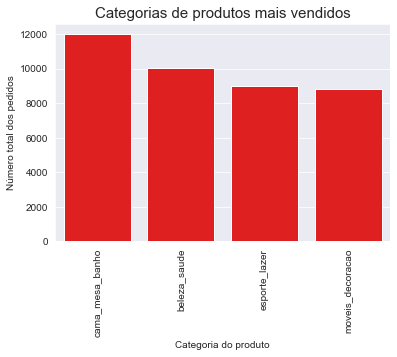

In [16]:
# Visualizando as 4 categorias mais vendidos
sns.barplot(x='product_category_name',y='order_count',data=categorias_mais_vendidas[:4],color="red")
plt.xlabel("Categoria do produto")
plt.ylabel("Número total dos pedidos")
plt.title("Categorias de produtos mais vendidos", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

<h1>Preços médios das 4 categorias de produtos mais vendidas</h1>
<br>

In [17]:
categorias_preco = df.groupby('product_category_name')['price'].mean().to_frame().reset_index()
cama_mesa_banho = categorias_preco[categorias_preco['product_category_name'] == 'cama_mesa_banho']
beleza_saude = categorias_preco[categorias_preco['product_category_name'] == 'beleza_saude']
esporte_lazer = categorias_preco[categorias_preco['product_category_name'] == 'esporte_lazer']
moveis_decoracao = categorias_preco[categorias_preco['product_category_name'] == 'moveis_decoracao']
quatro_categorias = pd.concat([cama_mesa_banho, beleza_saude, esporte_lazer, moveis_decoracao]).reset_index().sort_values(by='price', ascending=False)
quatro_categorias.head()

,index,product_category_name,price
1,11,beleza_saude,129.776435
2,32,esporte_lazer,114.340020
0,13,cama_mesa_banho,92.360132
3,54,moveis_decoracao,87.455696


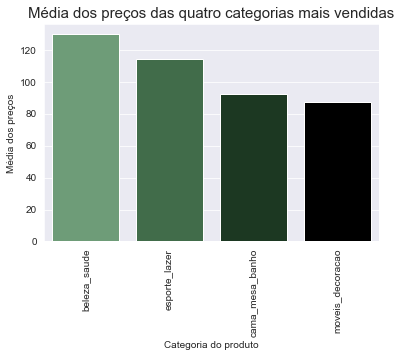

In [18]:
# Visualizando a média das 4 categorias mais vendidas
palette1 = sns.cubehelix_palette(4, start=2, rot=0, dark=0, light=.55)
sns.barplot(x='product_category_name',y='price',data=quatro_categorias, palette=palette1)
plt.xlabel("Categoria do produto")
plt.ylabel("Média dos preços")
plt.title("Média dos preços das quatro categorias mais vendidas", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

<h1>Observação</h1>
<br>
As quatro categorias que mais vendem são cama, mesa e banho, beleza e saúde, esporte e lazer, e moveis e decoração. Dentre elas, a categoria beleza e saúde possui a maior média de preços, com quase 130 reais, seguido por esporte e lazer com aproximadamente 115 reais. É necessário mais dados para se saber se são os negócios mais rentáveis do comércio eletrônico, como os custos, mas a tendência é que sejam realmente.
<br>
<br>
Segue abaixo um histograma que nos mostra, agora de maneira geral nos preços, para saber se nossos preços são simétricos. Para normalizar os dados, usarei log.

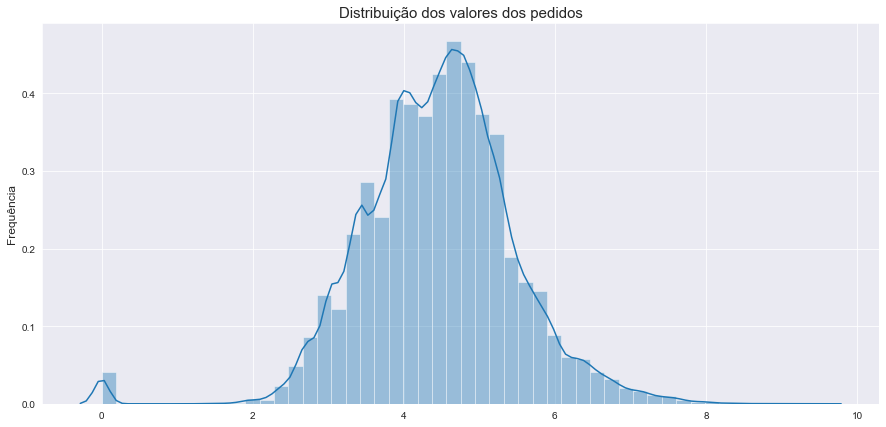

In [19]:
valor = df.groupby('order_id')['price'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15,7))
g = sns.distplot(np.log(valor['price'] + 1))
g.set_title("Distribuição dos valores dos pedidos", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequência", fontsize=12)
plt.show()

In [20]:
print("Assimetria dos preços:", skew(np.log(valor['price']+1)))

Assimetria dos preços: -0.3387900447013808


<b>Como a assimetria está entre -0,5 e 0,5, a distribuição é aproximadamente simétrica.</b>

<h1>Qual a tendência das vendas no tempo</h1>
<br>

In [21]:
## Criando colunas para dia, mês, ano, dia da semana e tempo:
df['ano'] = df['order_purchase_timestamp'].dt.year
df['dia do mes'] = df['order_purchase_timestamp'].dt.day
df['dia da semana'] = df['order_purchase_timestamp'].dt.weekday
df['mes'] = df['order_purchase_timestamp'].dt.month
df['hora'] = df['order_purchase_timestamp'].dt.hour

In [22]:
dia_e_hora = df.groupby(['dia da semana','hora']).agg({'order_id':'count'}).rename(columns={'order_id':'freq'}).reset_index()

In [23]:
weekmap = {0:'Seg', 1:'Ter', 2:'Qua', 3:'Qui', 4:'Sex', 5:'Sab', 6:'Dom'}
dia_e_hora['dia da semana'] = dia_e_hora['dia da semana'].map(weekmap)

In [24]:
# Ordenando para que o gráfico fique de maneira correta
dia_e_hora['dia da semana']=pd.Categorical(dia_e_hora['dia da semana'],categories=['Dom','Seg','Ter','Qua','Qui','Sex','Sab'],ordered=True)

In [25]:
dia_e_hora = dia_e_hora.pivot('dia da semana','hora','freq')

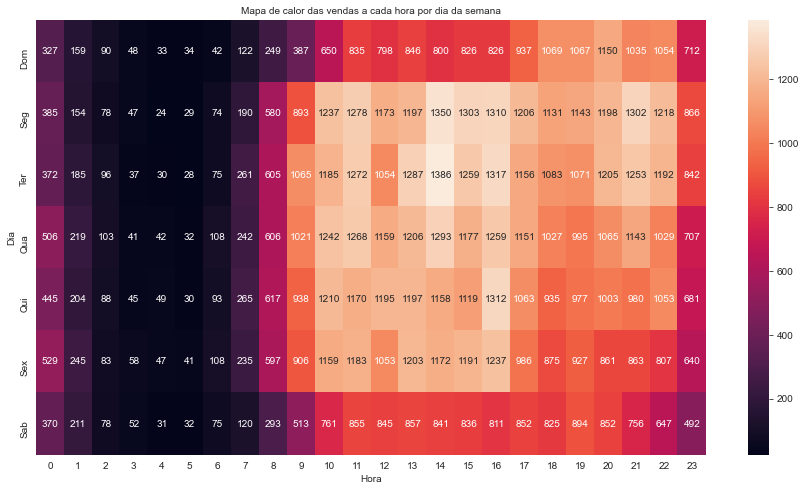

In [26]:
plt.figure(figsize=(15,8))
ax=sns.heatmap(dia_e_hora,annot=True,fmt="d")
ax.set_xlabel("Hora")
ax.set_ylabel("Dia")
ax.set_title("Mapa de calor das vendas a cada hora por dia da semana",size=10)
plt.show()

<h1>Observação</h1>
<br>
- Percebe-se que as vendas começam a aumentar a partir das 9 horas todos os dias e é maior durante a semana. 
<br>
- Sábado é o dia mais fraco de vendas e elas só começam a melhorar a partir das 17 horas de domingo.
<br>
- O pico das vendas é entre 14 horas e 16 horas, durante a semana.

<h1>Desempenho de entrega</h1>
<br>

In [27]:
df['entrega no tempo (em horas)'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.total_seconds() / 86400

In [28]:
df['entrega'] = df['entrega no tempo (em horas)'] >= 0

In [29]:
df['entrega'] = df['entrega'].astype('str')

In [30]:
df['entrega'].values[df['entrega'] == 'True'] = 'no tempo'

In [31]:
df['entrega'].values[df['entrega'] == 'False'] = 'atrasado'

In [32]:
entregas = df["entrega"].value_counts()
entregas

no tempo    106662
atrasado     12489
Name: entrega, dtype: int64

In [33]:
porcentagem_entrega = (df['entrega'].value_counts() / df['entrega'].value_counts().sum()) *100
porcentagem_entrega = porcentagem_entrega.to_frame().reset_index()
porcentagem_entrega

,index,entrega
0,no tempo,89.518342
1,atrasado,10.481658


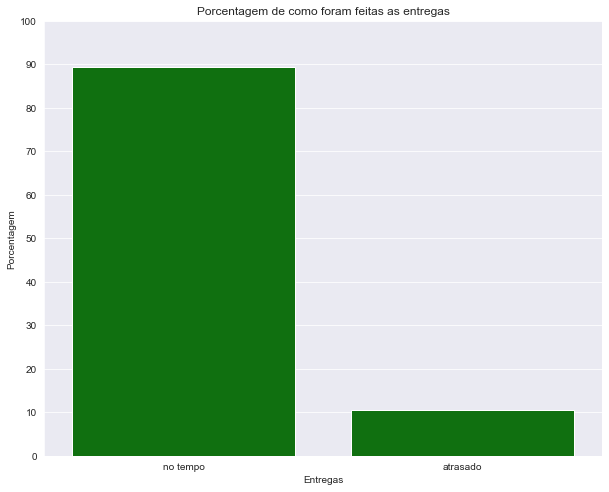

In [34]:
plt.figure(figsize=(10,8))
sns.barplot(x='index', y='entrega', data=porcentagem_entrega, color='green')
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title('Porcentagem de como foram feitas as entregas')
plt.xlabel('Entregas')
plt.ylabel('Porcentagem')
plt.show()

In [35]:
# Estados com mais problemas de entrega
atraso = df[df["entrega"] == "atrasado"]["customer_state"].value_counts()
atraso

SP    4212
RJ    2488
MG    1045
BA     684
RS     578
SC     510
PR     430
ES     323
CE     287
GO     259
PE     254
DF     248
MA     199
PA     167
AL     128
MT     121
PI     110
MS     104
PB      92
SE      78
RN      76
TO      44
RO      22
RR      11
AM      10
AP       5
AC       4
Name: customer_state, dtype: int64

<h1>Observação</h1>
<br>
10% das entregas foram feitas de maneira atrasada, que apesar de parecer pouca coisa, num volume grande de dados como o nosso, é muita coisa. E a maioria dos atrasos ocorre no estado de São Paulo. Acredito que uma forma de melhorar a entrega seria de conseguir parcerias com transportadoras mais experientes, com renome no mercado e que são da região e um melhor planejamento das vendas.

<h1>Quais categorias de produtos possuem clientes satisfeitos e insatisfeitos</h1>
<br>

In [36]:
filtrado = df.groupby(['product_category_name'])["review_score"].describe().sort_values(['count'], ascending=False)

In [37]:
filtrado

,count,mean,std,min,25%,50%,75%,max
product_category_name,,,,,,,,
cama_mesa_banho,11990.0,3.867056,1.465711,1.0,3.00,5.0,5.00,5.0
beleza_saude,10033.0,4.118210,1.353115,1.0,4.00,5.0,5.00,5.0
esporte_lazer,9005.0,4.092837,1.364101,1.0,4.00,5.0,5.00,5.0
moveis_decoracao,8833.0,3.895279,1.470811,1.0,3.00,5.0,5.00,5.0
informatica_acessorios,8151.0,3.926144,1.452712,1.0,3.00,5.0,5.00,5.0
...,...,...,...,...,...,...,...,...
portateis_cozinha_e_preparadores_de_alimentos,15.0,3.266667,1.579632,1.0,2.00,3.0,5.00,5.0
cds_dvds_musicais,14.0,4.642857,0.633324,3.0,4.25,5.0,5.00,5.0
pc_gamer,10.0,3.100000,1.852926,1.0,1.00,4.0,4.75,5.0


In [38]:
data = filtrado.sort_values(['count'], ascending=False)

In [39]:
dez_mais_vendidos = data[data['count'] > 4000]

In [40]:
cinco_melhores = dez_mais_vendidos.sort_values(['mean'], ascending=False).head()
cinco_melhores

,count,mean,std,min,25%,50%,75%,max
product_category_name,,,,,,,,
brinquedos,4281.0,4.142490,1.340515,1.0,4.0,5.0,5.0,5.0
beleza_saude,10033.0,4.118210,1.353115,1.0,4.0,5.0,5.0,5.0
esporte_lazer,9005.0,4.092837,1.364101,1.0,4.0,5.0,5.0,5.0
utilidades_domesticas,7380.0,4.045257,1.377165,1.0,4.0,5.0,5.0,5.0
automotivo,4400.0,4.038636,1.375708,1.0,4.0,5.0,5.0,5.0


In [41]:
cinco_piores = dez_mais_vendidos.sort_values(['mean']).head()
cinco_piores

,count,mean,std,min,25%,50%,75%,max
product_category_name,,,,,,,,
cama_mesa_banho,11990.0,3.867056,1.465711,1.0,3.0,5.0,5.0,5.0
moveis_decoracao,8833.0,3.895279,1.470811,1.0,3.0,5.0,5.0,5.0
informatica_acessorios,8151.0,3.926144,1.452712,1.0,3.0,5.0,5.0,5.0
telefonia,4726.0,3.938214,1.394468,1.0,3.0,5.0,5.0,5.0
relogios_presentes,6213.0,4.000644,1.402784,1.0,3.0,5.0,5.0,5.0


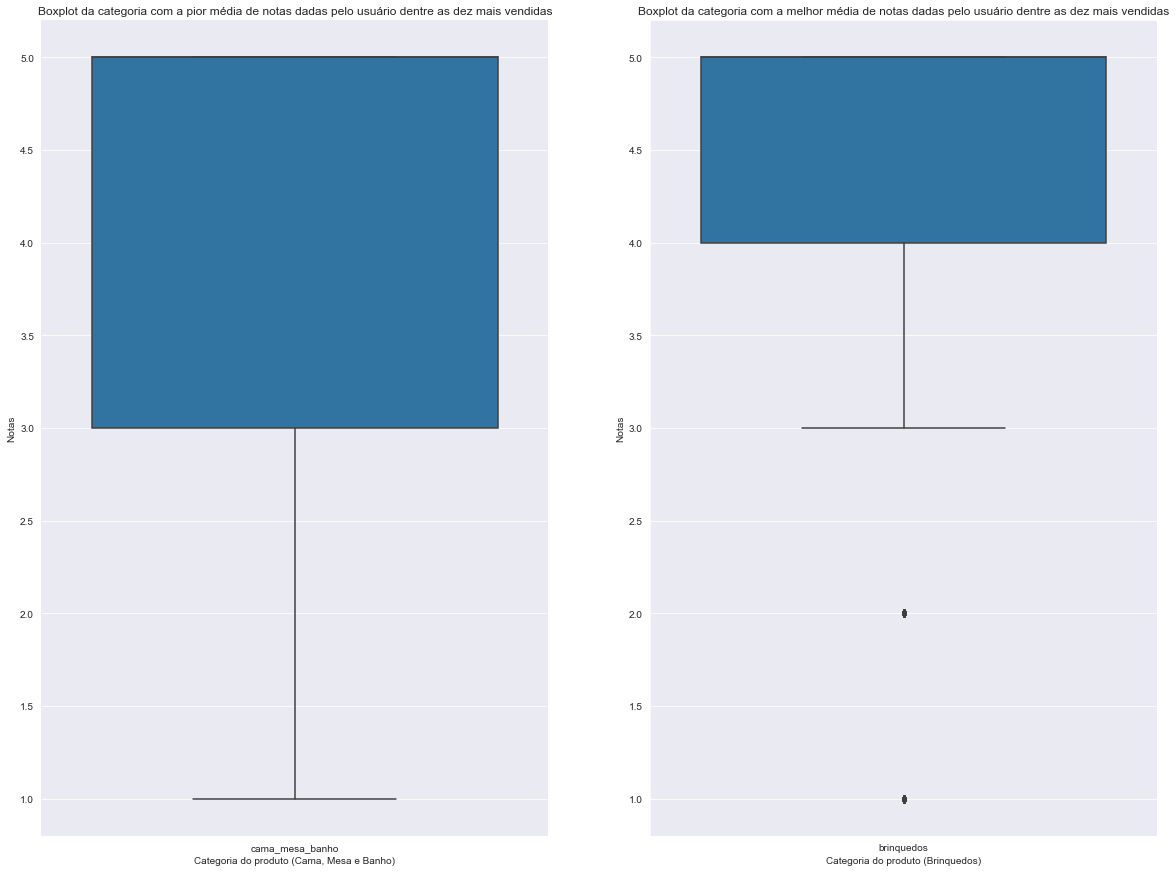

In [42]:
cama_mesa_banho = df[df['product_category_name'] == 'cama_mesa_banho'].dropna(subset=['product_category_name', 'review_score'])
brinquedos = df[df['product_category_name'] == 'brinquedos'].dropna(subset=['product_category_name', 'review_score'])
sns.set_style("darkgrid")
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
sns.despine(left=True, bottom=True)
sns.boxplot(x='product_category_name', y='review_score', data=cama_mesa_banho)
plt.title('Boxplot da categoria com a pior média de notas dadas pelo usuário dentre as dez mais vendidas')
plt.ylabel('Notas')
plt.xlabel('Categoria do produto (Cama, Mesa e Banho)')
plt.subplot(1, 2, 2)
sns.boxplot(x='product_category_name', y='review_score', data=brinquedos)
plt.title('Boxplot da categoria com a melhor média de notas dadas pelo usuário dentre as dez mais vendidas')
plt.ylabel('Notas')
plt.xlabel('Categoria do produto (Brinquedos)')
plt.show()

<h1>Observação</h1>
<br>
Foi filtrado as dez categorias mais vendidas do conjunto de dados. Nele, é visto que a categoria de produto com a pior média de notas foi a cama, mesa e banho, com 3.86. A categoria com a melhor média foi a de brinquedos, com 4.14. Esta categoria possui alguns outliers com notas 1 e 2, mas a grande maioria das notas fica entre 3 e 5, com 75% das notas entre 4 e 5. Já cama, mesa e banho, não possui outliers, com 75% das suas notas ficando entre 3 e 5.
<br>
<br>
Outro ponto a se destacar é que a variância (quadrado do desvio padrão) é alta, o que mostra que mesmo na mesma categoria, há diversas experiências com o mesmo tipo de produto, podendo decorrer de várias variáveis, como entrega e qualidade do produto.

<h1>Pergunta Principal</h1>
<br>
Tentarei responder uma pergunta principal: <b>Como deixar os clientes mais satisfeitos com as compras do comércio eletrônico no Brasil?</b>

<Figure size 432x288 with 0 Axes>

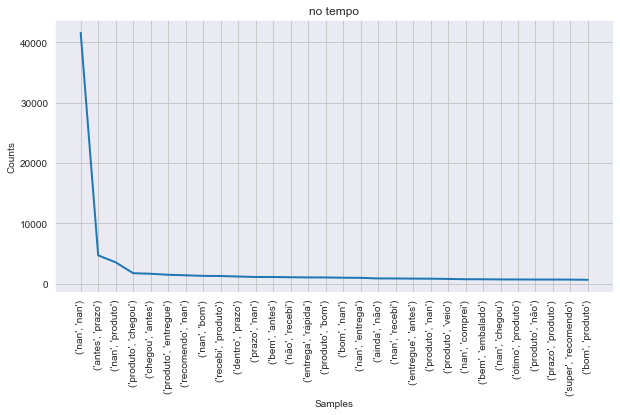

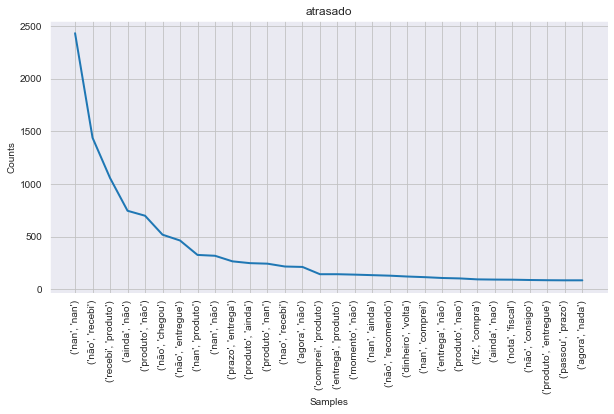

In [43]:

plt.figure()
subcategorias = ["no tempo", "atrasado"]
for subcategoria in subcategorias:
    dfGenerico = df[df["entrega"] == subcategoria]
    review = (" ".join([str(i) for i in dfGenerico["review_comment_message"]])).lower().replace("produtoq", "produto")
    review
    # Removendo a pontuação e Tokenizando o texto
    tokenizer = RegexpTokenizer(r'\w+')
    cleanText = tokenizer.tokenize(review)

    # Removendo as StopWords
    stopWords = stopwords.words('portuguese')
    stopWords.remove("não")
    filtered_words = [word for word in cleanText if word not in stopWords]

    # Criando Bigramas
    filtered_words = nltk.ngrams(filtered_words, 2)

    filtered_words

    freq = nltk.FreqDist(filtered_words)
    plt.figure(figsize=(10, 5))
    plt.title(subcategoria)
    freq.plot(30)

In [44]:
nota_com_entrega = df.groupby('entrega')['review_score'].describe().sort_values(['count'], ascending=False)
nota_com_entrega

,count,mean,std,min,25%,50%,75%,max
entrega,,,,,,,,
no tempo,106662.0,4.195899,1.246808,1.0,4.0,5.0,5.0,5.0
atrasado,12489.0,2.312755,1.607716,1.0,1.0,1.0,4.0,5.0


<h1>Observação</h1>
<br>
O que podemos observar é que a grande maioria das combinações de palavras nas revisões que temos é relacionado a entrega, seja nas entregas atrasadas, seja nas entregas em tempo. Alguns comentários relacionados a entrega atrasada fala-se até de que não recebeu o produto. 
<br>
<br>
<b>É um indicativo de que se houver uma melhora na entrega dos produtos, ou seja, chegar no prazo ou até antes do prazo, a satisfação do cliente será maior</b>. Só verificar as diferenças das médias de notas entre as entregas feitas no tempo (média 4.19) e atrasado (média 2.31). 
<br>
<br>
<b>Acredito então que havendo uma preocupação maior com as entregas, o cliente do comércio eletrônico brasileiro terá uma experiência mais agradável e sairá mais satisfeito.</b>